# Andrew's model work for Milestone 4, based on David's

In [1]:
import itertools as it
import matplotlib
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import scipy as sp
import sklearn.preprocessing as Preprocessing
import datetime

from itertools import combinations
from sklearn.cross_validation import KFold as kfold
from sklearn.decomposition import TruncatedSVD as tSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier as Boost
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from scipy.io import mmread

%matplotlib inline
plt.style.use('ggplot') 
from IPython.display import display, HTML

In [2]:
### specify processed data files to generate - full/partial, partial %, and train/test
### Note: this cell is the same in both notebooks

# load and clean full dataset?
load_full = False

# if not loading and cleaning full dataset, what sample percentage?
sample_percent = 10

if load_full:
    pct_str = ""
else: # not load_full
    pct_str = str(sample_percent) + "_pct"
    
# use training or testing data to generate minor files?
minor_use_train = True
if minor_use_train:
    mode_str = "train"
else: # not minor_use_train
    mode_str = "test"
    
### set intermediate file names
dir_str = "./intermediate_files/"

processed_data_train_file = dir_str + "processed_data_" + "train" + pct_str + ".json"
processed_data_test_file = dir_str + "processed_data_" + "test" + pct_str + ".json"

nlp_data_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
nlp_data_train_file = dir_str + "nlp_data_" + mode_str + pct_str + ".json"
term_freqs_file = dir_str + "term_freqs_" + mode_str + pct_str + ".mtx"
diff_terms_file = dir_str + "diff_terms_" + mode_str + pct_str + ".json"

In [3]:
### load processed data
data = pd.read_json(processed_data_train_file)
data_nlp = pd.read_json(nlp_data_file)
desc_matrix_coo = mmread(term_freqs_file)
desc_matrix = sp.sparse.csr_matrix(desc_matrix_coo)
count_cols_df = pd.read_json(diff_terms_file)

count_cols_bool = count_cols_df.values > 0.0

In [4]:
x = data.drop('loan_status', 1)
y = data['loan_status']

x_nlp = data_nlp.drop('loan_status', 1)
y_nlp = data_nlp['loan_status']

# Explore and clean up and standardize data

In [6]:
pd.to_datetime(x.issue_date).dt.year.value_counts()

2013    5037
2014    4854
2012    3499
2015    1880
2011    1398
2010     816
2009     334
2008     108
Name: issue_date, dtype: int64

In [7]:
# del x['verif_status']
x.describe().T

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,25%,50%,75%,max
annual_income,17926.0,72998.041509,49542.969545,4.000000e+03,45000.000000,62026.800000,88000.000000,1.900000e+06
cpi,17926.0,0.020903,0.000711,1.959404e-02,0.020243,0.020924,0.021465,2.321584e-02
delinq_2_yrs,17926.0,0.208636,0.512151,0.000000e+00,0.000000,0.000000,0.000000,2.000000e+00
desc_len,6241.0,295.298991,329.114589,1.000000e+00,NaN,NaN,NaN,5.016000e+03
dti,17926.0,0.002401,0.001115,0.000000e+00,0.001566,0.002355,0.003204,5.445891e-03
gdp,17926.0,0.999738,0.000037,9.995437e-01,0.999715,0.999744,0.999766,9.998077e-01
index,17926.0,255113.786790,218543.306888,3.600000e+01,98422.750000,196835.000000,365741.500000,8.873710e+05
inquiry_6_mos,17926.0,0.815296,0.965960,0.000000e+00,0.000000,1.000000,1.000000,3.000000e+00
installment,17926.0,419.866960,245.186650,2.251000e+01,240.995000,366.695000,549.122500,1.407010e+03
interest_rate,17926.0,13.737496,4.406043,5.320000e+00,10.740000,13.490000,16.550000,2.849000e+01


In [10]:
# earliest_credit is not really a good indicator -- we want to know how long has elapsed since then
# See http://stackoverflow.com/questions/17414130/pandas-datetime-calculate-number-of-weeks-between-dates-in-two-columns
x['months_since_earliest_credit'] = (
    (pd.to_datetime(x.issue_date) - pd.to_datetime(x.earliest_credit))/np.timedelta64(1,'M')
).round()

In [11]:
x.columns

Index([               u'address_state',                u'annual_income',
                                u'cpi',                 u'delinq_2_yrs',
                           u'desc_len',                  u'description',
                                u'dti',              u'earliest_credit',
                      u'employ_length',                 u'employ_title',
                                u'gdp',                   u'home_owner',
                              u'index',          u'initial_list_status',
                      u'inquiry_6_mos',                  u'installment',
                      u'interest_rate',                          u'ipr',
                         u'issue_date',                  u'loan_amount',
                       u'loan_purpose',                u'loan_subgrade',
                          u'loan_term',     u'months_since_last_record',
                      u'open_accounts',                   u'recoveries',
                         u'revol_util',            

In [12]:
def expand_x(x, x_orig):
    x_expanded = pd.DataFrame()
    for colname in x.columns:
        print colname, x[colname].dtype
        if colname in ('description', 'verif_status', 'loan_subgrade', 
                       'index', 'recoveries', 'issue_date', 'earliest_credit'):
            continue
        if x[colname].dtype == 'object':
            values = x[colname].fillna('MISSING')
            value_columns = values.value_counts().index
            if len(value_columns) > 50:
                value_columns = value_columns[:50]
            for val in value_columns:
                x_expanded[colname + '__' + val.replace(' ', '_')] = (values == val).astype(int)
        else:
            values = x[colname].fillna(x[colname].median())
            sd = np.nanstd(x_orig[colname])
            if sd < 1e-10:
                sd = 1
            x_expanded[colname] = (values - np.nanmean(x_orig[colname]))/sd
    return x_expanded

In [13]:
x_expanded = expand_x(x, x)

address_state object
annual_income float64
cpi float64
delinq_2_yrs int64
desc_len float64
description object
dti float64
earliest_credit object
employ_length object
employ_title object
gdp float64
home_owner object
index int64
initial_list_status object
inquiry_6_mos int64
installment float64
interest_rate float64
ipr float64
issue_date object
loan_amount int64
loan_purpose object
loan_subgrade int64
loan_term int64
months_since_last_record float64
open_accounts int64
recoveries float64
revol_util float64
rir float64
total_accounts int64
unemploy float64
verif_status float64
months_since_earliest_credit float64


In [14]:
x_expanded.describe().T

,count,mean,std,min,25%,50%,75%,max
address_state__CA,17926.0,1.671315e-01,0.373104,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NY,17926.0,8.663394e-02,0.281306,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__TX,17926.0,7.659266e-02,0.265951,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__FL,17926.0,6.911748e-02,0.253661,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__NJ,17926.0,4.061140e-02,0.197394,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__IL,17926.0,3.631597e-02,0.187080,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__PA,17926.0,3.402879e-02,0.181308,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__GA,17926.0,3.341515e-02,0.179723,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__OH,17926.0,3.151846e-02,0.174719,0.000000,0.000000,0.000000,0.000000,1.000000
address_state__VA,17926.0,2.878501e-02,0.167206,0.000000,0.000000,0.000000,0.000000,1.000000


In [15]:
x_expanded.columns

Index([             u'address_state__CA',              u'address_state__NY',
                    u'address_state__TX',              u'address_state__FL',
                    u'address_state__NJ',              u'address_state__IL',
                    u'address_state__PA',              u'address_state__GA',
                    u'address_state__OH',              u'address_state__VA',
       ...
            u'loan_purpose__educational', u'loan_purpose__renewable_energy',
                            u'loan_term',       u'months_since_last_record',
                        u'open_accounts',                     u'revol_util',
                                  u'rir',                 u'total_accounts',
                             u'unemploy',   u'months_since_earliest_credit'],
      dtype='object', length=149)

In [16]:
# be prepared to split stuff up by year of issue
years = pd.to_datetime(x.issue_date).dt.year

# Start evaluating models

In [17]:
for yr in set(years.values):
    rf = RFC(random_state=1729,
             max_depth=5,
             n_estimators=100,
             oob_score=True
            ).fit(x_expanded[years==yr], y[years==yr])
    print "%d  oob score: %.3f  baseline: %.3f" % (yr, rf.oob_score_, 1-y[years==yr].mean(),)

2008  oob score: 0.833  baseline: 0.833
2009  oob score: 0.886  baseline: 0.886
2010  oob score: 0.898  baseline: 0.898
2011  oob score: 0.833  baseline: 0.833
2012  oob score: 0.835  baseline: 0.835
2013  oob score: 0.790  baseline: 0.790
2014  oob score: 0.794  baseline: 0.794
2015  oob score: 0.897  baseline: 0.897


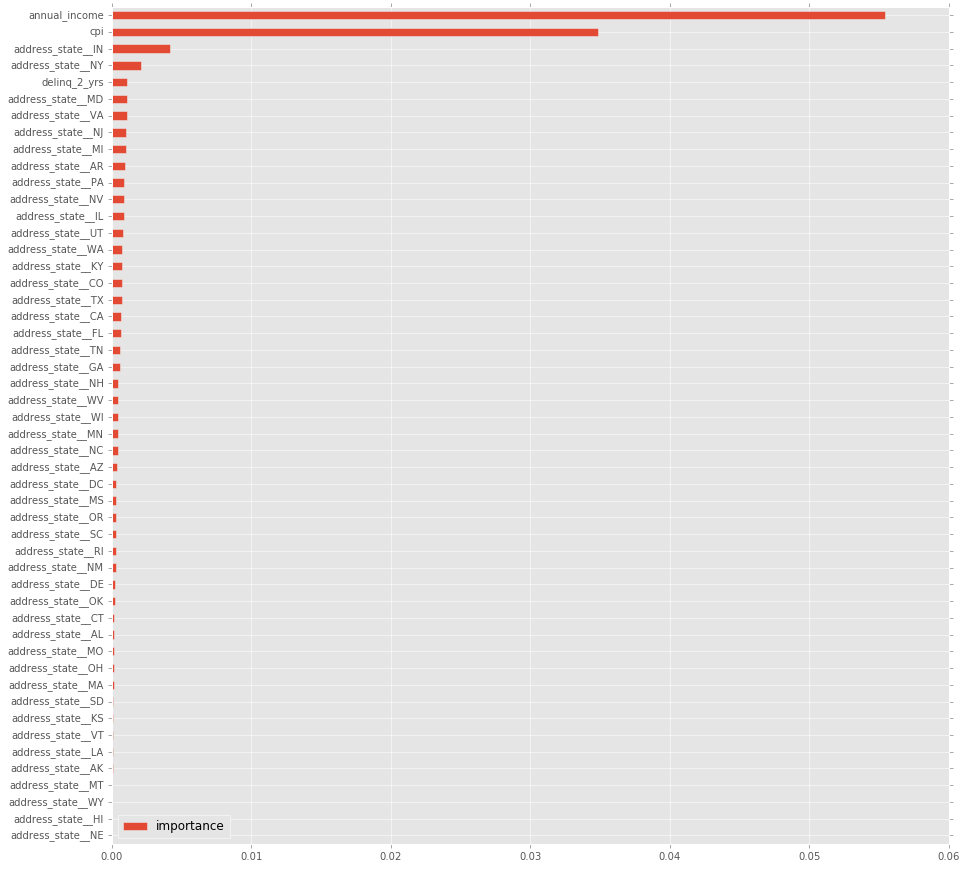

In [18]:
# One RF with all years combined; what predictors matter?
rf = RFC(random_state=1729,
         max_depth=5,
         n_estimators=100,
         oob_score=True
        ).fit(x_expanded, y)
plt.figure(figsize=(15,15))
pd.DataFrame(rf.feature_importances_, 
             index=x_expanded.columns,
             columns=['importance'],
             ).iloc[0:50,:].sort_values(by='importance',
                           ascending=True,
             ).plot(kind='barh', ax=plt.gca())
plt.show()

In [19]:
def eval_model_by_year(model_factory, columns=None, prob_threshold=0.5):
    k = 5
    np.random.seed(1729)
    if columns is None:
        x_local = x_expanded
    else:
        x_local = x_expanded[columns]
    for yr in set(years.values):
        indexes = np.where(years==yr)[0]
        np.random.shuffle(indexes)

        cm_accum = np.zeros((2, 2))
        f1_accum = 0
        score = 0
        weighted_score = 0

        for i in range(k):
            train_indexes = list(indexes[0:len(indexes)*i/k]) + list(indexes[len(indexes)*(i+1)/k:])
            test_indexes = indexes[len(indexes)*i/k:len(indexes)*(i+1)/k]
        
            #print "TRAIN ", train_indexes
            #print 'TEST', test_indexes
            #print "Y", y.iloc[test_indexes]
            
            # model = model_factory().fit(x_expanded[years==yr], y[years==yr])
            # score = model.score(x_expanded[years==yr], y[years==yr]) / k
            model = model_factory().fit(x_local.iloc[train_indexes,:], y.iloc[train_indexes])
            yhat = model.predict(x_local)
            score += model.score(x_local.iloc[test_indexes], y.iloc[test_indexes]) / k
            yhat_weighted = (model.predict_proba(x_local)[:,0] > prob_threshold)[test_indexes]
            weighted_score += (y.iloc[test_indexes][yhat_weighted]).mean() / k
            cm_accum += confusion_matrix(y.iloc[test_indexes], yhat[test_indexes])
            f1_accum += f1_score(y.iloc[test_indexes], yhat[test_indexes], pos_label = 1) / k
        
        print "%d  score: %.3f  baseline: %.3f   wscore: %.3f   f1: %.3f"  % (
            yr, score, 1-y[years==yr].mean(), 1-weighted_score, f1_accum)

# TODO: Confusion matrix (right now, we're not doing well enough to worry about that)
# TODO: Pretty-print
# TODO: Store results to allow side-by-side

In [20]:
eval_model_by_year(lambda: Log_Reg())

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2008  score: 0.798  baseline: 0.833   wscore: 0.835   f1: 0.080
2009  score: 0.874  baseline: 0.886   wscore: 0.885   f1: 0.000
2010  score: 0.890  baseline: 0.898   wscore: 0.901   f1: 0.087
2011  score: 0.820  baseline: 0.833   wscore: 0.844   f1: 0.171
2012  score: 0.837  baseline: 0.835   wscore: 0.844   f1: 0.138
2013  score: 0.790  baseline: 0.790   wscore: 0.805   f1: 0.193
2014  score: 0.792  baseline: 0.794   wscore: 0.811   f1: 0.212
2015  score: 0.891  baseline: 0.897   wscore: 0.898   f1: 0.050


In [21]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'))

2008  score: 0.731  baseline: 0.833   wscore: 0.859   f1: 0.222
2009  score: 0.676  baseline: 0.886   wscore: 0.873   f1: 0.072
2010  score: 0.725  baseline: 0.898   wscore: 0.933   f1: 0.279
2011  score: 0.673  baseline: 0.833   wscore: 0.888   f1: 0.365
2012  score: 0.648  baseline: 0.835   wscore: 0.889   f1: 0.355
2013  score: 0.655  baseline: 0.790   wscore: 0.869   f1: 0.432
2014  score: 0.662  baseline: 0.794   wscore: 0.869   f1: 0.425
2015  score: 0.695  baseline: 0.897   wscore: 0.933   f1: 0.270


In [22]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), prob_threshold=.6)

2008  score: 0.731  baseline: 0.833   wscore: 0.877   f1: 0.222
2009  score: 0.676  baseline: 0.886   wscore: 0.854   f1: 0.072
2010  score: 0.725  baseline: 0.898   wscore: 0.937   f1: 0.279
2011  score: 0.673  baseline: 0.833   wscore: 0.907   f1: 0.365
2012  score: 0.648  baseline: 0.835   wscore: 0.903   f1: 0.355
2013  score: 0.655  baseline: 0.790   wscore: 0.891   f1: 0.432
2014  score: 0.662  baseline: 0.794   wscore: 0.890   f1: 0.425
2015  score: 0.695  baseline: 0.897   wscore: 0.943   f1: 0.270


In [23]:
eval_model_by_year(lambda: QDA())

C:\Users\agreene\AppData\Local\Continuum\Anaconda2\envs\amg1\lib\site-packages\sklearn\discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2008  score: 0.613  baseline: 0.833   wscore: 0.807   f1: 0.134
2009  score: 0.838  baseline: 0.886   wscore: 0.883   f1: 0.031
2010  score: 0.885  baseline: 0.898   wscore: 0.899   f1: 0.047
2011  score: 0.208  baseline: 0.833   wscore: 0.832   f1: 0.281
2012  score: 0.185  baseline: 0.835   wscore: 0.883   f1: 0.285
2013  score: 0.222  baseline: 0.790   wscore: 0.782   f1: 0.346
2014  score: 0.245  baseline: 0.794   wscore: 0.830   f1: 0.342
2015  score: 0.226  baseline: 0.897   wscore: 0.913   f1: 0.187


In [24]:
eval_model_by_year(lambda: SVC(class_weight='balanced', probability=True))

2008  score: 0.659  baseline: 0.833   wscore: 0.835   f1: 0.350
2009  score: 0.605  baseline: 0.886   wscore: 0.886   f1: 0.165
2010  score: 0.679  baseline: 0.898   wscore: 0.898   f1: 0.254
2011  score: 0.660  baseline: 0.833   wscore: 0.834   f1: 0.366
2012  score: 0.663  baseline: 0.835   wscore: 0.836   f1: 0.345
2013  score: 0.649  baseline: 0.790   wscore: 0.801   f1: 0.442
2014  score: 0.673  baseline: 0.794   wscore: 0.807   f1: 0.444
2015  score: 0.681  baseline: 0.897   wscore: 0.897   f1: 0.279


In [25]:
# TODO: Try again, this time fitting a regression against the payments received

In [26]:
# Curious -- what are the 95 CI for the baselines?
for yr in set(years.values):
    yr_n = (years == yr).sum()
    yr_def = (y[years == yr]).sum()
    yr_p = (y[years == yr]).mean()
    yr_se = (yr_p * (1.0-yr_p) / yr_n)
    print "y=%4d   n=%4d   d=%4d   p: %.3f | %.3f | %.3f" % (yr, yr_n, yr_def, yr_p - 1.96*yr_se, yr_p, yr_p + 1.96*yr_se)

y=2008   n= 108   d=  18   p: 0.164 | 0.167 | 0.169
y=2009   n= 334   d=  38   p: 0.113 | 0.114 | 0.114
y=2010   n= 816   d=  83   p: 0.101 | 0.102 | 0.102
y=2011   n=1398   d= 233   p: 0.166 | 0.167 | 0.167
y=2012   n=3499   d= 579   p: 0.165 | 0.165 | 0.166
y=2013   n=5037   d=1059   p: 0.210 | 0.210 | 0.210
y=2014   n=4854   d=1000   p: 0.206 | 0.206 | 0.206
y=2015   n=1880   d= 194   p: 0.103 | 0.103 | 0.103


In [27]:
# Default rate for small business is higher, right?
print y.mean()
print y[x_expanded.loan_purpose__small_business == 1].mean()

0.178734798617
0.300884955752


In [28]:
eval_model_by_year(lambda: Log_Reg(class_weight='balanced'), ['loan_purpose__small_business'])

2008  score: 0.707  baseline: 0.833   wscore: 0.777   f1: 0.064
2009  score: 0.859  baseline: 0.886   wscore: 0.891   f1: 0.096
2010  score: 0.884  baseline: 0.898   wscore: 0.906   f1: 0.161
2011  score: 0.824  baseline: 0.833   wscore: 0.842   f1: 0.141
2012  score: 0.824  baseline: 0.835   wscore: 0.839   f1: 0.097
2013  score: 0.784  baseline: 0.790   wscore: 0.791   f1: 0.030
2014  score: 0.790  baseline: 0.794   wscore: 0.795   f1: 0.030
2015  score: 0.561  baseline: 0.897   wscore: 0.840   f1: 0.060


In [29]:
eval_model_by_year(lambda: RFC(
        random_state=1729,
        max_depth=8,
        n_estimators=300
        )
)

2008  score: 0.844  baseline: 0.833   wscore: 0.844   f1: 0.133
2009  score: 0.886  baseline: 0.886   wscore: 0.886   f1: 0.000
2010  score: 0.898  baseline: 0.898   wscore: 0.898   f1: 0.000
2011  score: 0.833  baseline: 0.833   wscore: 0.833   f1: 0.000
2012  score: 0.834  baseline: 0.835   wscore: 0.834   f1: 0.000
2013  score: 0.790  baseline: 0.790   wscore: 0.790   f1: 0.000
2014  score: 0.794  baseline: 0.794   wscore: 0.794   f1: 0.004
2015  score: 0.897  baseline: 0.897   wscore: 0.897   f1: 0.000


In [30]:
# TODO: try different depths

In [31]:
# LogReg is doing well.. what are the largest coefficients?
lr = Log_Reg().fit(x_expanded, y)
lr_coeff = pd.DataFrame(lr.coef_.T, index=x_expanded.columns)
lr_coeff.columns = ['coeff']
lr_coeff['abs'] = lr_coeff.coeff.abs()

In [32]:
lr_coeff.sort_values('abs', ascending=False)

,coeff,abs
employ_title__owner,1.268984,1.268984
employ_title__Branch_Manager,-1.043603,1.043603
employ_title__Program_Manager,-0.869251,0.869251
employ_title__Project_Manager,-0.836161,0.836161
employ_title__Accountant,-0.802217,0.802217
employ_title__Vice_President,-0.796174,0.796174
employ_title__US_Air_Force,0.784249,0.784249
loan_purpose__educational,-0.754841,0.754841
employ_title__manager,0.661736,0.661736
employ_title__Wells_Fargo_Bank,-0.582626,0.582626


In [33]:
lr_probs = lr.predict_proba(x_expanded)[:,0]

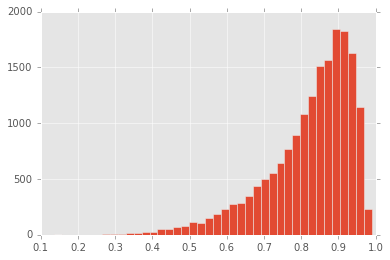

In [34]:
plt.hist(lr_probs ,bins=40)
plt.show()

In [35]:
1 - y.groupby([int(p*20)/20.0 for p in lr_probs]).mean()

0.10    0.000000
0.15    1.000000
0.20    0.666667
0.25    0.250000
0.30    0.407407
0.35    0.304348
0.40    0.486486
0.45    0.408805
0.50    0.561594
0.55    0.592677
0.60    0.599693
0.65    0.672632
0.70    0.725723
0.75    0.766667
0.80    0.833159
0.85    0.872384
0.90    0.927291
0.95    0.968511
Name: loan_status, dtype: float64